### Importing Libraries

In [2]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from PIL import Image

from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MaxPooling2D, Dropout, BatchNormalization, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


### Downloading and Extracting the datset

In [ ]:
# https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

# !unzip /content/drive/MyDrive/Colab\ Notebooks/malaria\ dataset.zip

### Resizing the dataset

In [16]:
IMG_DIR = r"/content/cell_images"
SIZE = 64
# we can use numpy array or pandas dataframe to hold images
dataset = []
label = []

parasitized_images = os.listdir(os.path.join(IMG_DIR, 'Parasitized'))
uninfected_images = os.listdir(os.path.join(IMG_DIR, 'Uninfected'))

for i,image_name  in enumerate(parasitized_images):
    if (image_name.split(".")[1] == 'png'):
        image = cv2.imread(os.path.join(IMG_DIR, 'Parasitized', image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (SIZE, SIZE))
        dataset.append(image)
        label.append(0)

for i,image_name  in enumerate(uninfected_images):
    if (image_name.split(".")[1] == 'png'):
        image = cv2.imread(os.path.join(IMG_DIR, 'Uninfected', image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (SIZE, SIZE))
        dataset.append(image)
        label.append(1)




### displaying images

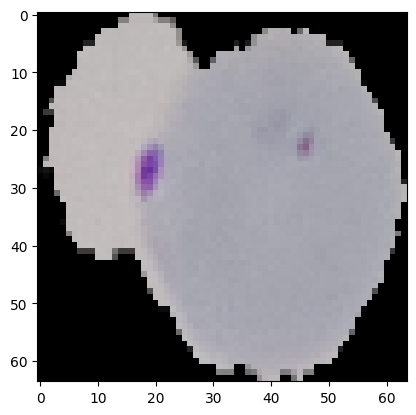

In [22]:
plt.imshow(dataset[1])
plt.show()

### Model Building

In [18]:
INPUT_SHAPE = (SIZE, SIZE, 3)

inp = Input(shape = INPUT_SHAPE)

conv1 = Conv2D(32, (3,3),activation='relu', padding='same')(inp)
pool1 = MaxPooling2D((2,2))(conv1)
norm1 = BatchNormalization(axis = -1)(pool1)
drop1 = Dropout(0.2)(norm1)

conv2 = Conv2D(32, (3,3),activation='relu', padding='same')(drop1)
pool2 = MaxPooling2D((2,2))(conv2)
norm2 = BatchNormalization(axis = -1)(pool2)
drop2 = Dropout(0.2)(norm2)

flat = Flatten()(drop2)

hidden1 = Dense(512,activation='relu')(flat)
norm3 = BatchNormalization(axis = -1)(hidden1)
drop3 = Dropout(0.2)(norm3)

hidden2 = Dense(256,activation='relu')(drop3)
norm4 = BatchNormalization(axis = -1)(hidden2)
drop4 = Dropout(0.2)(norm4)

out = Dense(2,activation='sigmoid')(drop4)

model = keras.Model(inputs = inp, outputs = out)

model.compile(optimizer = Adam(),
              loss = CategoricalCrossentropy(),
              metrics = ['accuracy']
              )

print(model.summary())

#later we need to put this in a function and put it on multithreading


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248

### Model Training

In [19]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(dataset,to_categorical(np.array(label)),test_size = 0.2, random_state = 0)

history = model.fit(np.array(x_train),y_train, batch_size = 128, verbose = 1, epochs = 10,validation_split = 0.1, shuffle = False )



Epoch 1/10
156/156 [==============================] - 13s 23ms/step - loss: 0.6118 - accuracy: 0.7253 - val_loss: 1.6428 - val_accuracy: 0.6662
Epoch 2/10
156/156 [==============================] - 3s 19ms/step - loss: 0.2593 - accuracy: 0.9025 - val_loss: 0.8744 - val_accuracy: 0.8154
Epoch 3/10
156/156 [==============================] - 3s 20ms/step - loss: 0.1979 - accuracy: 0.9281 - val_loss: 0.1936 - val_accuracy: 0.9379
Epoch 4/10
156/156 [==============================] - 3s 21ms/step - loss: 0.1658 - accuracy: 0.9385 - val_loss: 0.3082 - val_accuracy: 0.9229
Epoch 5/10
156/156 [==============================] - 3s 22ms/step - loss: 0.1463 - accuracy: 0.9459 - val_loss: 0.4047 - val_accuracy: 0.8898
Epoch 6/10
156/156 [==============================] - 3s 19ms/step - loss: 0.1286 - accuracy: 0.9543 - val_loss: 0.1610 - val_accuracy: 0.9442
Epoch 7/10
156/156 [==============================] - 3s 19ms/step - loss: 0.1135 - accuracy: 0.9590 - val_loss: 0.1619 - val_accuracy: 0.946

### Model Evaluation and displaying accuracy and loss graphs

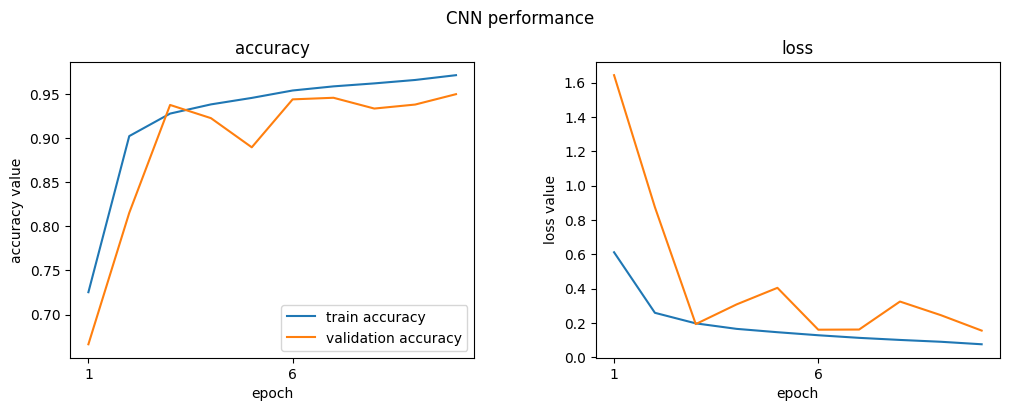

In [21]:

print("test accuracy: {:.2f}%".format(model.evaluate(np.array(x_test), np.array(y_test))[1]*100))


f,(ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))
t = f.suptitle("CNN performance",fontsize =12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label = 'train accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='validation accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('accuracy value')
ax1.set_xlabel('epoch')
ax1.set_title('accuracy')
l1 = ax1.legend(loc = 'best')



ax2.plot(epoch_list, history.history['loss'], label = 'train loss')
ax2.plot(epoch_list, history.history['val_loss'], label='validation loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('loss value')
ax2.set_xlabel('epoch')
ax2.set_title('loss')
l1 = ax1.legend(loc = 'best')

